# Принятие решений в бизнесе

Исследование проводится для крупного интернет-магазина.   

В нашем распоряжении подготовленный совместно с отделом маркетинга список гипотез для увеличения выручки, который необходимо приоритизировать. Кроме того, имеются результаты A/B-теста, которые нуждаются в анализе. 

**ЦЕЛЬ ИССЛЕДОВАНИЯ**:
1. Выбрать наиболее приоритетные гипотезы из представленного списка.
2. По результатам А/В-теста проверить гипотезу об отсутствии статистически значимых различий в конверсии заказов между группами по "сырым" данным и данным после фильтрации аномалий.
3.  По результатам А/В-теста проверить гипотезу об отсутствии статистически значимых различий в среднем чеке заказа между группами по "сырым" данным и данным после фильтрации аномалий.

**ХОД ИССЛЕДОВАНИЯ**

Данные получили из трех файлов: для одной части - hypothesis.csv, для другой - orders.csv и visitors.csv.    
О качестве данных ничего не известно. Поэтому перед исследованием данных и расчетом показателей понадобится их обзор и предобработка. 
Таким образом, исследование пройдёт в три этапа:

1. Обзор и предобработка данных.
2. Приоритизация гипотез.
3. Анализ A/B-теста.

### Загрузка данных и подготовка их к анализу

Импортируем нужные библиотеки, настроим отображение таблиц и загрузим данные в переменные `hypothesis`, `visitors` и `orders`:

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None) # настроим отображение всех столбцов на экране
pd.set_option('display.max_colwidth', None) # настроим отображение текста в ячейках
pd.set_option('display.float_format', '{:.3f}'.format) # настроим отображение вещественных чисел до 3 наков

In [3]:
#загружаем данные в переменные
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),  # гипотезы
    pd.read_csv('/datasets/orders.csv'),  # результаты А/В-теста с данными о заказах
    pd.read_csv('/datasets/visitors.csv'),  # результаты А/В-теста с данными о визитах
)

---

Для быстрого изучения данных создадим функцию `data_info`, которая выведет на экран первые 5 строк таблицы, основную инфоромацию по ней с типами данных каждого признака, информацию о числе пропусков и о количистве дубликатов. Поочередно применим ее к изучаемыми датасетам.

In [4]:
def data_info(df):
    # выводим первые 5 строк датафрема
    display(df.head())
    # применяем метод info()
    print()
    print('Общая информация:')
    print(df.info())
    print()
    # считаем пропущенные значения:
    print('Число пропущенных значений:')
    print(df.isna().sum())
    print()
    # находим число строк-дубликатов в датафреме
    print('Количество строк-дубликатов:', df.duplicated().sum())

---

**Датасет "hypothesis"**

In [5]:
data_info(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

Число пропущенных значений:
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 1px; padding: 20px">  
    
В таблице 5 столбцов. Встречаются разные типы данных в столбцах: object и int64.

Согласно документации:    
**Hypothesis** — краткое описание гипотезы;   
**Reach** — охват пользователей по 10-балльной шкале;   
**Impact** — влияние на пользователей по 10-балльной шкале;   
**Confidence** — уверенность в гипотезе по 10-балльной шкале;    
**Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной.   


В названиях колонок видны нарушения стиля, над которым нужно поработать.   
Пропущенных значений в датасете нет, строки-дубликаты отсутствуют, типы данных соответствуют заявленному описанию. 

In [6]:
#приведем название столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

**Датасет "orders"**

In [7]:
data_info(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

Число пропущенных значений:
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 1px; padding: 20px">  
    
В таблице 5 столбцов. Встречаются разные типы данных в столбцах: int64 и object. 

Согласно документации:       
**transactionId** — идентификатор заказа;    
**visitorId** — идентификатор пользователя, совершившего заказ;   
**date** — дата, когда был совершён заказ;   
**revenue** — выручка заказа;   
**group** — группа A/B-теста, в которую попал заказ.    

В названиях колонок также видны нарушения стиля.  
Тип данных признака `date` нужно изменить на datetime.  
Пропущенных значений в датафрейме нет, строки-дубликаты отсутствуют.

In [8]:
# приведем наименования столбцов в соответствии с хорошим стилем
orders = orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'})

#изменим тип данных на datetime
orders['date'] = pd.to_datetime(orders['date'])

# выведем обновленную информацию для проверки
orders.dtypes

transaction_id             int64
visitor_id                 int64
date              datetime64[ns]
revenue                    int64
group                     object
dtype: object

**Датасет "visitors"**

In [9]:
data_info(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None

Число пропущенных значений:
date        0
group       0
visitors    0
dtype: int64

Количество строк-дубликатов: 0


<div style="border:solid Gray 1px; padding: 20px">  
    
В таблице 3 столбца. Встречаются разные типы данных в столбцах: int64 и object. 

Согласно документации:          
**date** — дата;   
**group** — группа A/B-теста;   
**visitors** — количество пользователей в указанную дату в указанной группе A/B-теста   
    

С названиями признаков - все в порядке, нарушения стиля нет.  
Тип данных признака `date` нужно изменить на datetime.  
Пропущенных значений в датафрейме нет, строки-дубликаты отсутствуют.

In [10]:
#изменим тип данных на datetime
visitors['date'] = pd.to_datetime(visitors['date'])

# выведем обновленную информацию для проверки
visitors.dtypes

date        datetime64[ns]
group               object
visitors             int64
dtype: object

**Вывод**   
Данные загружены и предобработаны, пропуски и явные дубликаты не выявлены, столбцы с данными о времени приведены к нужному типу, исправлен стиль заголовков.

###  Приоритизация гипотез.

`hypothesis` содержит 9 гипотез по увеличению выручки интернет-магазина, которые будем приоритизировать способами ICE и RICE.

#### Фреймворк ICE для приоритизации гипотез

Для расчетов будем использовать формулу: $$ICE = \frac{Impact * Confidence}{Efforts}$$

где    
    **_Impact_** - *влияние на пользователей, их опыт и удовлетворение от продукта;*    
    **_Confidence_** - *уверенность в гипотезе, что это изменение повлияет на пользователей именно так;*  
    **_Efforts_** - *затраты ресурсов на проверку гипотезы.*

In [11]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='ICE', ascending=False).head()

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000


Для наглядности, отобразим все гипотезы в порядке убывания приоритета:

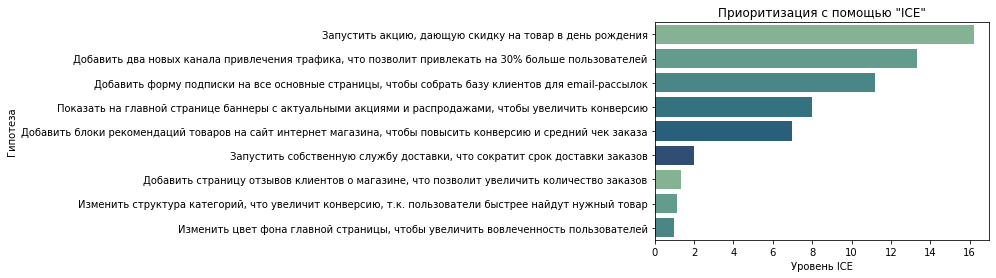

In [12]:
colors = sns.color_palette("crest")
sns.barplot(data=hypothesis.sort_values(by='ICE', ascending=False), x='ICE', y='hypothesis', palette=colors)
plt.title('Приоритизация с помощью "ICE"')
plt.xlabel('Уровень ICE')
plt.ylabel('Гипотеза')
plt.show()

Таким образом, наиболее **перспективными по "ICE" являются гипотезы с индексами: 8, 0, 7, 6 и 2.**

#### Фреймворк RICE для приоритизации гипотез

Для расчетов будем использовать формулу: $$RICE = \frac{Reach * Impact * Confidence}{Efforts}$$

где    
    **_Reach_** - *охват пользователей, которых затронет изменение;*    
    **_Impact_** - *влияние на пользователей, их опыт и удовлетворение от продукта;*    
    **_Confidence_** - *уверенность в гипотезе, что это изменение повлияет на пользователей именно так;*  
    **_Efforts_** - *затраты ресурсов на проверку гипотезы.*

In [13]:
# рассчитываем приоритет RICE
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='RICE', ascending=False).head()

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000,56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000,40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.200


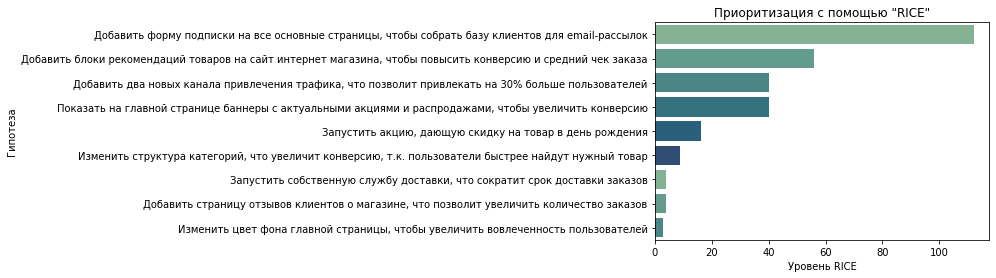

In [14]:
sns.barplot(data=hypothesis.sort_values(by='RICE', ascending=False), x='RICE', y='hypothesis', palette=colors)
plt.title('Приоритизация с помощью "RICE"')
plt.xlabel('Уровень RICE')
plt.ylabel('Гипотеза')
plt.show()

Снова наиболее **перспективными по "RICE" являются те же гипотезы, но приоритеты среди них существенно изменились. Индексы расположились в следующем порядке: 7, 2, 0, 6 и 8.**

Сопоставим данные. Выведем на экран гипотезу, уровень RICE и уровень ICE, закрасив уровни приоритетов разными цветами: максимальные значения окрасим в багрово-коричневый оттенок, минимальные - в светло-желтый.

In [15]:
hypothesis[['hypothesis', 'RICE', 'ICE']].sort_values(by='RICE', ascending=False).style.background_gradient(cmap='YlOrRd')

,hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000,11.200000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000,7.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000,13.333333
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000,8.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000,1.125000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000,1.333333
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000,1.000000


**Вывод**    
По результатам обоих методов, наиболее приоритетными можно считать пятерку одних и тех же гипотез.   

Согласно методу ICE гипотезы стоит проверять в следующем порядке:
1. Запустить акцию, дающую скидку на товар в день рождения
2. Добавить два новых канала привлечения трафика
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
5. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

Согласно методу RICE запускать акцию, дающую скидку на товар в день рождения - стоит лишь в пятую очередь. Наиболее перспективными здесь могут стать гипотезы: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа".    
Так произошло, потому что при втором методе подсчета учитывается то, как много пользователей затронет изменение, а у этих двух гипотез охват пользователей `"reach"` больше, чем у остальных. 

###  Анализ A/B-теста

Результаты А/В-теста описаны в файлах `orders` и `visitors`. Для начала узнаем о продолжительности эксперимента: выведем макисмальную и минимальную даты в файлах. Затем узнаем сколько, в среднем, пользователей было в день в каждой группе за время эксперимента и сколько уникальных пользователей сделали заказы.

In [16]:
orders.head(3)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [17]:
print('Минимальная дата:', orders['date'].min())
print('Максимальная дата:', orders['date'].max())

Минимальная дата: 2019-08-01 00:00:00
Максимальная дата: 2019-08-31 00:00:00


In [18]:
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [19]:
print('Минимальная дата:', visitors['date'].min())
print('Максимальная дата:', visitors['date'].max())

Минимальная дата: 2019-08-01 00:00:00
Максимальная дата: 2019-08-31 00:00:00


In [20]:
# находим среднее число пользователей в каждой из групп и сумарное число посещений
visitors.groupby('group').agg({'visitors': ['mean', 'sum']})

visitors       
          mean    sum
group                
A      604.387  18736
B      610.194  18916

**Зафиксирован месяц (31 день) эксперимента.** За время эксперимента среднее количество пользователей в день группы А составило 604 человека, а количество пользователей группы В - 610 человек. Также за все время теста в сегменте В зафиксировано на 180 посещений больше.   

Проверим сколько уникальных пользователей приняло участие в тесте и в каком соотношении они разбились на группы:

In [21]:
print('Число уникальных пользователей теста:', orders['visitor_id'].nunique())

# находим число уникальных пользователей, сделавших заказ в каждой из групп
orders.groupby('group').agg({'visitor_id' : 'nunique'})

Число уникальных пользователей теста: 1031


,visitor_id
group,
A,503
B,586


Интересно, что **общее число уникальных пользователей не соответствует общему числу пользователей по группам.** Получается, что некоторые пользователи увидели обе версии, а это уже ошибка теста, которая может привести к ложным результатам. Найдем таких пользователей:

In [22]:
# отбираем пользователей группы А
visitors_a = orders[orders['group']=='A']['visitor_id']
# отбираем пользователей группы В
visitors_b = orders[orders['group']=='B']['visitor_id']

# Создаем список с идентификаторами пользователей, попавших в обе группы
duplicated_visitors=orders.loc[
    orders['visitor_id'].isin(visitors_a) & 
    orders['visitor_id'].isin(visitors_b),'visitor_id'
].unique()
# Считаем их количество
print('Число пользователей, попавших в обе группы:', len(duplicated_visitors))

Число пользователей, попавших в обе группы: 58


**Задвоение произошло среди 58 пользователей. Поскольку мы не можем однозначно сказать, к какой группе должен относится каждый из них, для достоверности результатов - вынуждены убрать их из исследования, потому что не сможем понять какая именно версия повлияла на его решение.**

In [23]:
# исключаем "задвоенных" пользователей
orders = orders[(~(orders['visitor_id'].isin(duplicated_visitors)))]

# проверим что получилось
print('Число уникальных пользователей теста:', orders['visitor_id'].nunique())
orders.groupby('group').agg({'visitor_id' : 'nunique'})

Число уникальных пользователей теста: 973


,visitor_id
group,
A,445
B,528


Теперь всё сходится, но пришлось пожертвовать некоторыми заказами.    

Чтобы определить стоит ли останавливать тест, изучим графики кумулятивных значений.   
Прежде чем строить графики, соберём агрегированные кумулятивные по дням данные о заказах и посещениях в переменной `cumulative_data`.

In [24]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])
                    ].agg(
        {
            'date' : 'max', 
            'group' : 'max', 
            'transaction_id' : 'nunique', 
            'visitor_id' : 'nunique', 
            'revenue' : 'sum'
        }
    ), axis=1
).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group']
                                     )].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}),
    axis=1
).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и переименовываем названия столбцов
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


#### График кумулятивной выручки по группам

Разобъем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням на группы:

In [25]:
# группa А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# группa B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

На основе полученных данных строим график кумулятивной выручки по группам:

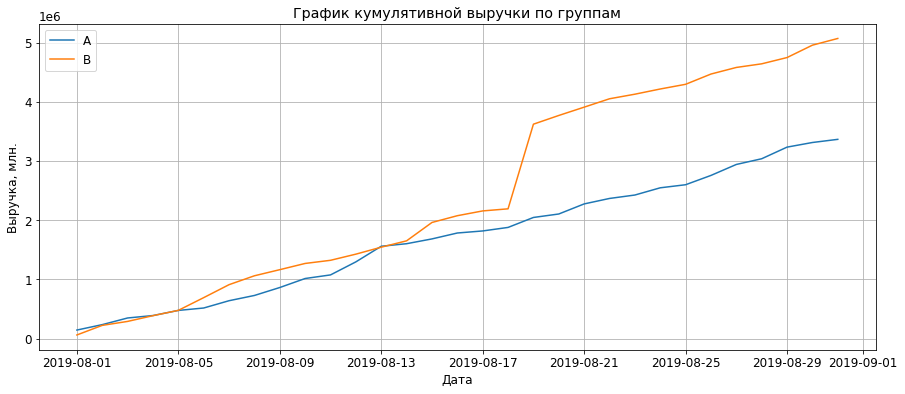

In [26]:
plt.rcParams['figure.figsize']=15,6
plt.rcParams['font.size'] = '12'

# Строим график выручки группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка, млн.')
plt.grid()
plt.legend() 
plt.show()

Наблюдается **резкий скачок выручки в группе В после 17 августа**, что может сигнализировать о наличии выбросов в этой группе: о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.   
Выручка сегмента А на протяжении всего времени, в целом, растет равномерно, и почти всегда она меньше выручки В.   

#### График кумулятивного среднего чека по группам

Кумулятивный средний чек найдем путем деления кумулятивной выручки на кумулятивное количество заказов на указанную дату:

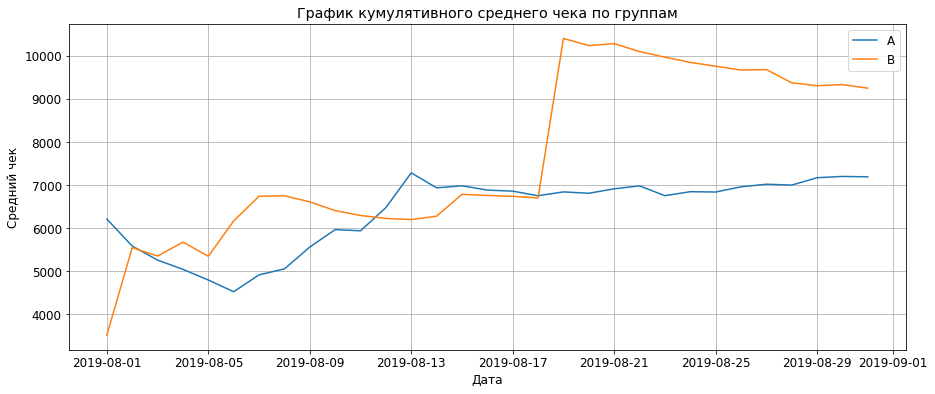

In [27]:
# Строим график среднего чека группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')

# Строим график среднего чека группы В
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid()
plt.legend() 
plt.show()

Примерно в середине месяца (у группы А чуть раньше, у группы В чуть позже) кумулятивный средний чек достиг своих пиковых значений в обоих группах. К концу периода кумулятивное значение среднего чека по сегментам - еще не совсем стабильно: еще видны небольшие колебания.      
Но важно, что кумулятивный средний чек в группе В также как и в предыдущем случае после 17 августа резко вырос, а затем начал снижаться, что вновь может свидетельствовать о наличии аномально крупных заказов в эти даты, которые могут негативно повлиять на результат теста.      
Поэтому принимать однозначное решение по метрике рано, потребуется дополнительный анализ выбросов.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного различия для среднего чека:

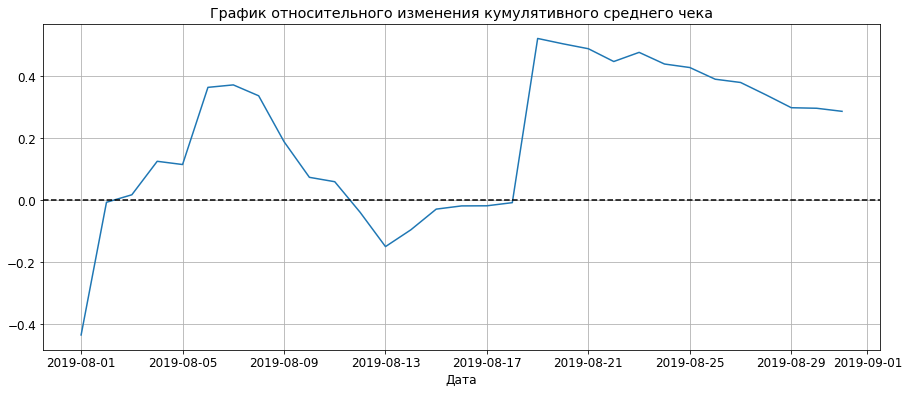

In [28]:
# собираем данные в одном датафрейме
merged_сumulative_revenue = cumulative_revenue_A.merge(
    cumulative_revenue_B, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

# cтроим отношение средних чеков
plt.plot(merged_сumulative_revenue['date'], 
         (merged_сumulative_revenue['revenueB']/merged_сumulative_revenue['ordersB'])/
         (merged_сumulative_revenue['revenueA']/merged_сumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека')
plt.xlabel('Дата')
plt.grid() 
plt.show()

Результаты теста значительно менялись в несколько дат.       
В целом, все три графика иллюстрируют схожую ситуацию и где-то точно есть крупные заказы и выбросы. Оценим их влияние позже.

#### График кумулятивного среднего количества заказов на посетителя по группам

В первую очередь рассчитаем кумулятивную конверсию, а затем построим графики в разбивке по группам:

In [29]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
cumulative_data.head(3)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.032
1,2019-08-01,B,17,17,59758,713,0.024
2,2019-08-02,A,42,36,234381,1338,0.031


In [30]:
# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

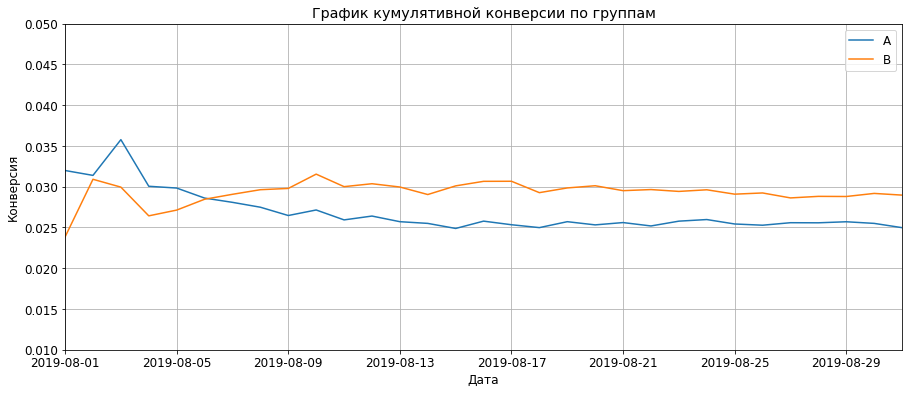

In [31]:
# строим графики
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.01, 0.05])
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.grid()
plt.legend() 
plt.show()

В начале теста конверсия у сегмента А была выше, чем у В. Но постепенно сегмент В выровнялся и зафиксировался примерно около одного значения, а сегмент А просел - и тоже зафиксировался. Абсолютное значение колебаний в начале и конце теста можно считать не высокими: примерно от 2,5% до 3,6%.     
В целом конверсия сегмента В пока выглядит лучше конверсии сегмента А.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

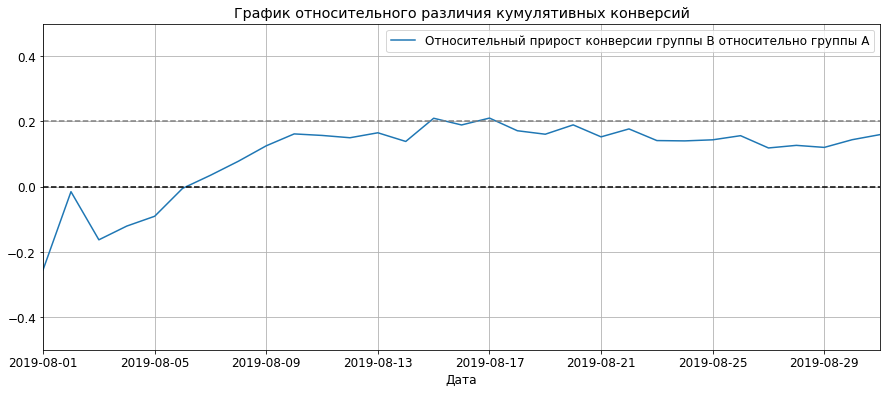

In [32]:
# собираем данные в одном датафрейме
merged_сumulative_сonversions = cumulative_data_A[['date','conversion']].merge(
    cumulative_data_B[['date','conversion']], 
    left_on='date',
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

# строим графики
plt.plot(merged_сumulative_сonversions['date'], 
         merged_сumulative_сonversions['conversionB']/merged_сumulative_сonversions['conversionA']-1,
         label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.5, 0.5])
plt.legend()
plt.grid()
plt.title('График относительного различия кумулятивных конверсий')
plt.xlabel('Дата')
plt.show()

В начале теста группа В немного проигрывала группе А. Но уже после шестого дня группа В стала лидировать по конверсии на протяжении всего теста и колебалась в пределах 10-20% прироста относительно группы А. В последние 10 дней теста она зафиксировалась примерно около прироста в 11%.

#### Точечный график количества заказов по пользователям

Настало время изучить аномальные заказы в данных. В первую очередь найдем число заказов по пользователям и сохраним в переменную `orders_by_users`

In [33]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'orders']

# отсортируем данные по убыванию числа заказов и выведем первые 5 строк
orders_by_users.sort_values(by='orders', ascending=False).head()

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


Построим диаграмму рассеяния методом *scatter()*:

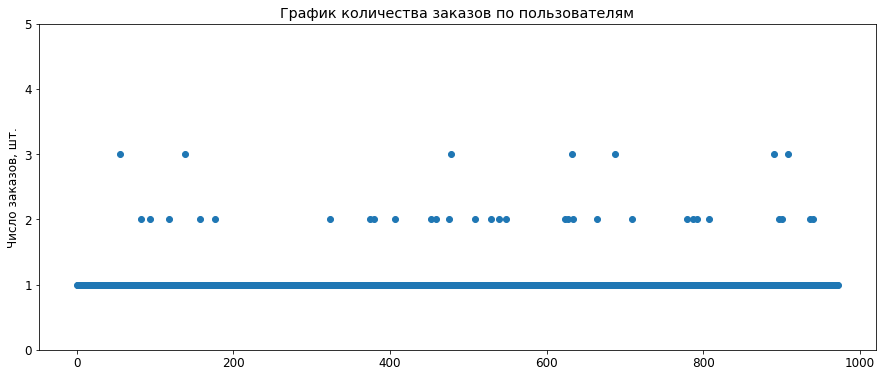

In [34]:
# серия из чисел от 0 до количества наблюдений в orders_by_users
x_values = pd.Series(range(0, len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders']) 
plt.title('График количества заказов по пользователям')
plt.ylabel('Число заказов, шт.')
plt.yticks(ticks=[0,1,2,3,4,5])
plt.show()

Из диаграммы видно, что большинство покупателей заказывали товары только один раз.    
Покупателей, заказавших товары более двух раз - немного и они вполне могут быть аномальными.    
Также есть часть покупателей, оформивших заказы дважды, но их точная доля не ясна, поэтому разумно посчитать перцентили количества заказов на одного пользователя.

#### Расчет 95-го и 99-го перцентилей количества заказов на пользователя

In [35]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли больше, чем 1 заказ, и не более 1% пользователей - больше, чем 2 заказа.    
Считаем разумным выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

#### Точечный график стоимостей заказов

Сначала посмотрим на 5 самых дорогих заказов за все время:

In [36]:
orders.sort_values(by='revenue', ascending=False).head(5)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A


**Самым дорогим стоимостью более 1 млн. единиц оказался заказ от 19 августа как раз из группы В, который может оказаться "виновником" резких скачков на кумулятивных графиках.** Для полноты картины построим точечный график стоимостей заказов:

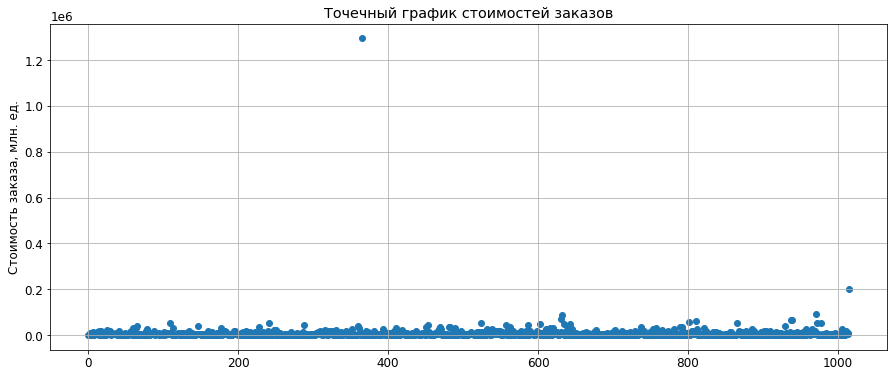

In [37]:
# генерируем номера наблюдений
x_values = pd.Series(range(0, len(orders['revenue'])))

#строим график
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа, млн. ед.')
plt.grid()
plt.show()

На графике упомянутый выше самый дорогостоящий заказ выглядит сверханомально. Однозначно аномальным выглядит и заказ стоимостью около 200 тыс. единиц.   
Есть некоторые заказы стоимостью около 100 тыс. единиц, но стоимость основной массы заказов не превышает и 50 тыс.    
Лучше доверимся перцентилям.

#### Расчет 95-го и 99-го перцентилей стоимости заказов

In [38]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более чем у 5 % заказов чек выше 26 785 единиц стоимости, и не более чем у 1% - выше 53 904 единиц.    
Считаем разумным определить верхнюю границу стоимости заказов в 26 785 единиц стоимости.

---

Далее будем рассчитывать статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами: сначала по «сырым» данным, а затем "очистим" данные от аномалий и вновь рассчитаем статистическую значимость.   
Но в первую очередь, подготовим данные к расчетам.    
Создадим вспомогательные таблицы с кумулятивными данными в разбивке по группам `visitors_A_cummulative` и `visitors_B_cummulative`, в которых отразим информацию о накопленном числе пользователей на каждую дату в определенной группе: 

In [39]:
# Отбираем число пользователей за каждую дату в группе А
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

# Рассчитываем накопленное число пользователей на каждую дату в группе А
visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']


# Отбираем число пользователей за каждую дату в группе B
visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

# Рассчитываем накопленное число пользователей на каждую дату в группе B
visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

Также создадим `orders_A_cummulative` и `orders_B_cummulative`, в которых отразим информацию о накопленном числе заказов на каждую дату в разных группах и об их накопленной стоимости:

In [40]:
# находим число заказов и их общую стоимость в группе А за каждый день
orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

# рассчитываем накопленное число заказов и накопленную стоимость в группе А на каждый день
orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_A_cummulative.columns = ['date', 'orders_сummulative_A', 'revenue_сummulative_A']


# находим число заказов и их общую стоимость в группе В за каждый день
orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_B_cummulative.columns = ['date', 'orders_cummulative_B', 'revenue_cummulative_B']

Объединим все данные методом *merge()* в переменной `data` и выведем результат:

In [41]:
data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_сummulative_A,revenue_сummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


---

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы:    
```
H_0: Различий в среднем количестве заказов между группами нет
H_1: Различия в среднем количестве заказов между группами есть

```


Создадим переменные `orders_by_users_A` и `orders_by_users_B`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов:

In [42]:
# находим число уникальных заказов для пользователей из группы А
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['visitor_id', 'orders']

# находим число уникальных заказов для пользователей из группы В
orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['visitor_id', 'orders']

Объявим переменные `sample_A` и `sample_B`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. И применим тест Манна-Уитни и и выведем относительное различие в среднем между группами:

In [43]:
# находим количество заказов для пользователей группы А
sample_A = pd.concat(
    [
        orders_by_users_A['orders'],
        pd.Series(0,index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])),
            name='orders',
        ),
    ],
    axis=0,
)

# находим количество заказов для пользователей группы В
sample_B = pd.concat(
    [
        orders_by_users_B['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])),
            name='orders',
        ),
    ],
    axis=0,
)

# рассчитываем p-value
print("{0:.5f}".format(stats.mannwhitneyu(sample_A, sample_B, alternative='two-sided')[1]))

print("{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

0.01102
0.160


p-value = 0,01102 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов на посетителя между группами нет - отвергаем. По «сырым» данным есть различия в среднем числе заказов групп A и B.    
Относительный прирост среднего группы В к конверсии группы А равен 16,0%.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы:    
```
H_0: Различий в среднем чеке заказа между группами нет
H_1: Различия в среднем чеке заказа между группами есть

```


In [44]:
# рассчитываем p-value тестом Манна-Уитни
print('{0:.5f}'.format(
    stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                       orders[orders['group']=='B']['revenue'], alternative='two-sided')[1])
     )

# oтносительный прирост среднего чека группы B
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.82949
0.287


p-value больше 0,05 - статистически значимых отличий в среднем чеке между группами нет. Стоит отметить, что относительное различие среднего чека между сегментами значительное - 28,7% (то есть средний чек группы B значительно выше среднего чека группы A).

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Сформулируем гипотезы:    
```
H_0: Различий в среднем количестве заказов между группами по отфильтрованным данным нет
H_1: Различия в среднем количестве заказов между группами по отфильтрованным данным есть

```


Выясним сколько в данных аномальных пользователей (в соответствии с верхними границами, которые мы приняли в результате расчета перцентилей):

In [45]:
# отбираем пользователей, у которых более 2 заказов
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 2]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
# и отбираем пользователей, у которых стоимость заказа превышает 26785 единиц
users_with_expensive_orders = orders[orders['revenue'] > 26785]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormal_users.shape[0])

58


Получается всего 58 аномальных пользователей. Проверим как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным.

In [46]:
# готовим выборку количества заказов по пользователям в группе А
sample_a_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# готовим выборку количества заказов по пользователям в группе В
sample_b_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# рассчитываем p-value
print('{0:.5f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered, alternative='two-sided')[1]))
print('{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

0.01235
0.182


Также как и в случае с "сырыми" данными, *p-value* говорит нам о том, что различия в среднем числе заказов групп A и B есть. "Очистка" данных ситуацию не изменила, а относительная разница между сегментами увеличилась до 18,2%.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

 Сформулируем гипотезы:    
```
H_0: Различий в среднем чеке заказа между группами по отфильтрованным данным нет
H_1: Различия в среднем чеке заказа между группами по отфильтрованным данным есть

```
Проверим что произошло с результами по среднему чеку.

In [47]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            alternative='two-sided'
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.646
-0.048


Значение p-value после "очистки" данных слегка снизилось, но осталось больше 0,05. Это говорит о том, что статистически значимых отличий в среднем чеке между группами нет.
Но важно отметить, что относительное различие среднего чека между сегментами изменилось кардинально: теперь средний чек группы B стал ниже среднего чека группы A (различие составляет 4,8%).

**Выводы по исследованию**

В ходе исследования установлены следующие факты:    
1. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий;    
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;  
3. График различия конверсий между группами сообщает, что результаты группы B лучше результатов группы A и они зафиксировались на одном уровне (сейчас они на 11% лучше результатов группы А);    
4. График различия среднего чека колеблется, что позволило обнаружить наличие аномалий. Сделать из этого графика определённые выводы нельзя.

Исходя из перечисленных фактов **следует остановить тест, признать победу группы В,**  так как ее конверсия значительно лучше.

Также стоит заострить внимание на наличии не качественно собранных данных теста: по каким-то причинам некоторые пользователи попали в обе группы, что может быть недоработкой разработчиков и специалистов, проводивших A/A-тестирование - было бы полезным разобраться в причинах.
